In [1]:
import bt
import yfinance as yf
import matplotlib.pyplot as plt
import talib

In [2]:
data = yf.download('AAPL', start='2020-01-01', end='2020-12-31', progress=False)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876106,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167610,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742661,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400543,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200


# SMA Backtesting

In [3]:
# Calculate the SMA
sma = data.rolling(20).mean()
sma

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-23,123.6690,125.213500,122.506999,124.106000,121.491190,105937900.0
2020-12-24,124.4575,126.049001,123.303499,124.903000,122.271398,104859445.0
2020-12-28,125.3285,127.041500,124.167999,125.908001,123.255224,108749190.0


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


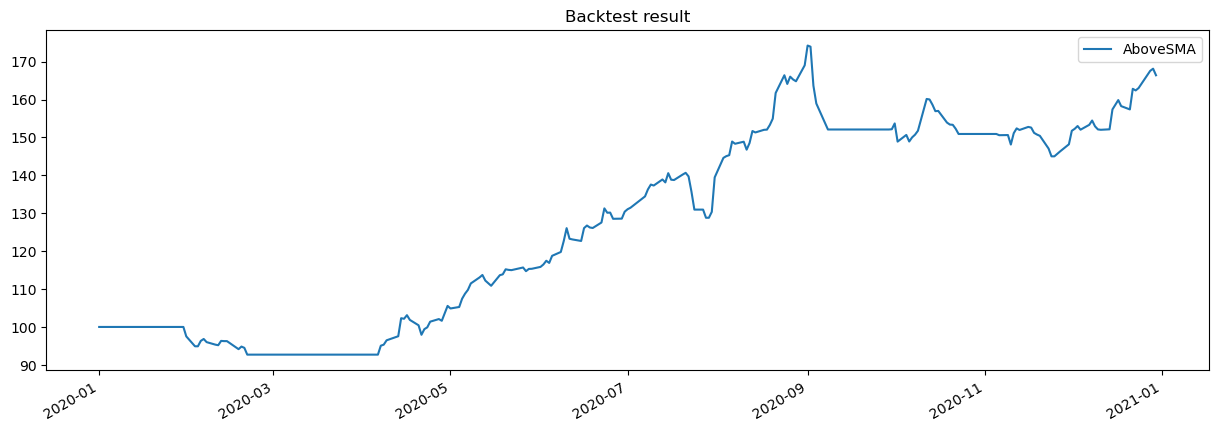

In [4]:
# Define the strategy
bt_strategy = bt.Strategy('AboveSMA', 
                          [bt.algos.SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

# Create the backtest and run it
bt_backtest = bt.Backtest(bt_strategy, data)
bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [5]:
bt_result.display()

Stat                 AboveSMA
-------------------  ----------
Start                2020-01-01
End                  2020-12-30
Risk-free rate       0.00%

Total Return         66.39%
Daily Sharpe         2.42
Daily Sortino        4.42
CAGR                 66.68%
Max Drawdown         -16.78%
Calmar Ratio         3.98

MTD                  12.29%
3m                   9.36%
6m                   27.60%
YTD                  66.39%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  66.68%

Daily Sharpe         2.42
Daily Sortino        4.42
Daily Mean (ann.)    53.38%
Daily Vol (ann.)     22.05%
Daily Skew           0.50
Daily Kurt           5.01
Best Day             6.98%
Worst Day            -5.92%

Monthly Sharpe       1.95
Monthly Sortino      5.89
Monthly Mean (ann.)  64.47%
Monthly Vol (ann.)   33.00%
Monthly Skew         -0.01
Monthly Kurt         -0.93
Best Month           21.20%
Worst Month          -9.98%

Yearly Sharpe  

# EMA Cross over <hr>
 - Go long when: Short EMA Crosses above Long EMA
 - Go short when: Short EMA Crosses below Long EMA

In [55]:
# Let's start by calculating EMA_short and EMA_long
EMA_short = talib.EMA(data['Close'], timeperiod=14).to_frame()
EMA_long = talib.EMA(data['Close'], timeperiod=30).to_frame()

EMA_long.head(), EMA_short.head()

(             0
 Date          
 2020-01-02 NaN
 2020-01-03 NaN
 2020-01-06 NaN
 2020-01-07 NaN
 2020-01-08 NaN,
              0
 Date          
 2020-01-02 NaN
 2020-01-03 NaN
 2020-01-06 NaN
 2020-01-07 NaN
 2020-01-08 NaN)

In [56]:
# Now lets define the singal
signal = EMA_long.copy()

# Initialize the `signal` column with 0
signal[:] = 0
# When the short EMA crosses the long EMA from below, it is a buy signal
signal[EMA_short > EMA_long] = 1
# When the short EMA crosses the long EMA from above, it is a sell signal
signal[EMA_short < EMA_long] = -1

signal.columns = ["Close"]

<Axes: xlabel='Date'>

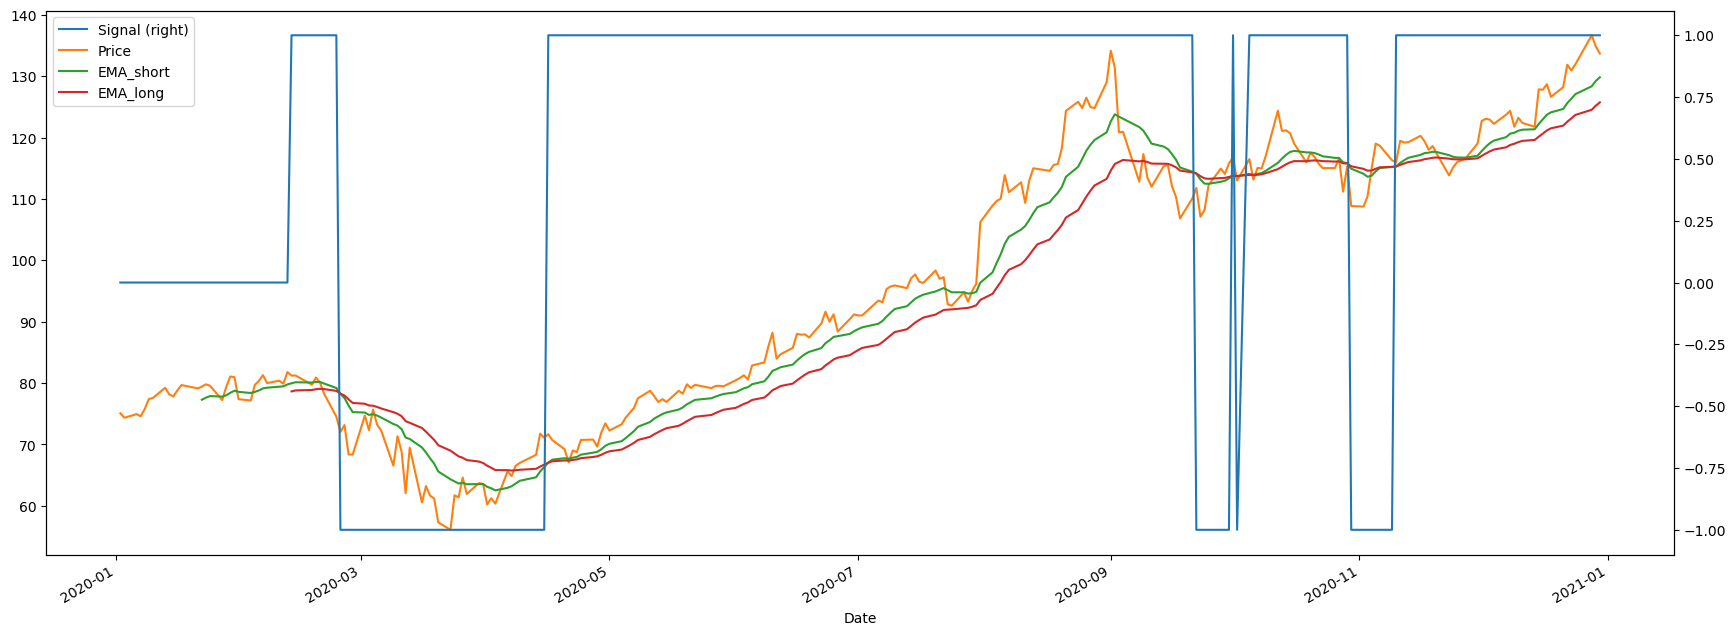

In [57]:
# Now we combine the dataframes
combined_data = bt.merge(signal, data['Close'], EMA_short, EMA_long)
combined_data.columns = ['Signal', 'Price', 'EMA_short', 'EMA_long']
combined_data.plot(secondary_y='Signal', figsize=(21,8))

In [58]:
# Now we define the startegy
bt_strategy = bt.Strategy(
    'EMA_Crossover',
    [
        bt.algos.WeighTarget(signal),
        bt.algos.Rebalance()
    ]
)

100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


<Axes: title={'center': 'Equity Progression'}>

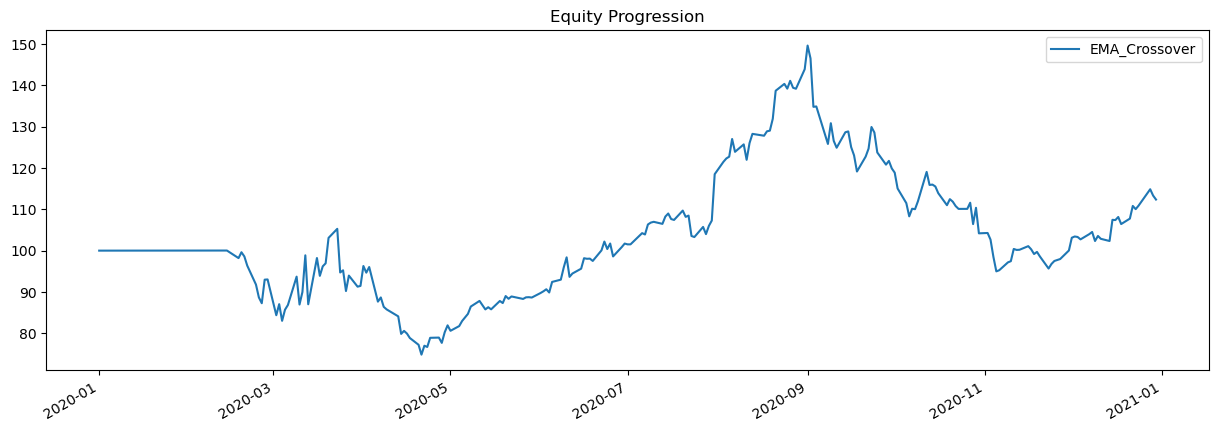

In [60]:
# Now create and backtest the strategy
bt_backtest = bt.Backtest(
    bt_strategy,
    data
)
result = bt.run(bt_backtest)
result.plot()

In [61]:
result.display()

Stat                 EMA_Crossover
-------------------  ---------------
Start                2020-01-01
End                  2020-12-30
Risk-free rate       0.00%

Total Return         12.37%
Daily Sharpe         0.48
Daily Sortino        0.76
CAGR                 12.41%
Max Drawdown         -36.53%
Calmar Ratio         0.34

MTD                  12.32%
3m                   -6.28%
6m                   10.47%
YTD                  12.37%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  12.41%

Daily Sharpe         0.48
Daily Sortino        0.76
Daily Mean (ann.)    22.23%
Daily Vol (ann.)     45.99%
Daily Skew           -0.10
Daily Kurt           4.15
Best Day             12.87%
Worst Day            -11.98%

Monthly Sharpe       0.48
Monthly Sortino      1.05
Monthly Mean (ann.)  22.21%
Monthly Vol (ann.)   45.92%
Monthly Skew         0.09
Monthly Kurt         -1.60
Best Month           21.44%
Worst Month          -16.69%

Y

# Mean revision Strategy | RSI Divergence <hr>
- RSI > 70: Overbought --> Short
- RSI < 30: Oversold --> Long

In [62]:
# Let's first create the RSI
RSI = talib.RSI(data.Close, timeperiod=14).to_frame()
RSI

,0
Date,
2020-01-02,NaN
2020-01-03,NaN
2020-01-06,NaN
2020-01-07,NaN
2020-01-08,NaN
...,...
2020-12-23,66.417825
2020-12-24,67.866386
2020-12-28,73.597952


In [68]:
# Now lets create the signal
signal = RSI.copy()

# Initialize the `signal` column with 0.0
signal[:] = 0.0
signal[RSI > 70] = -1.0 # Sell signal
signal[RSI < 30] = 1.0 # Buy signal
signal.columns = ['Close']
signal

,Close
Date,
2020-01-02,0.0
2020-01-03,0.0
2020-01-06,0.0
2020-01-07,0.0
2020-01-08,0.0
...,...
2020-12-23,0.0
2020-12-24,0.0
2020-12-28,-1.0


<Axes: xlabel='Date'>

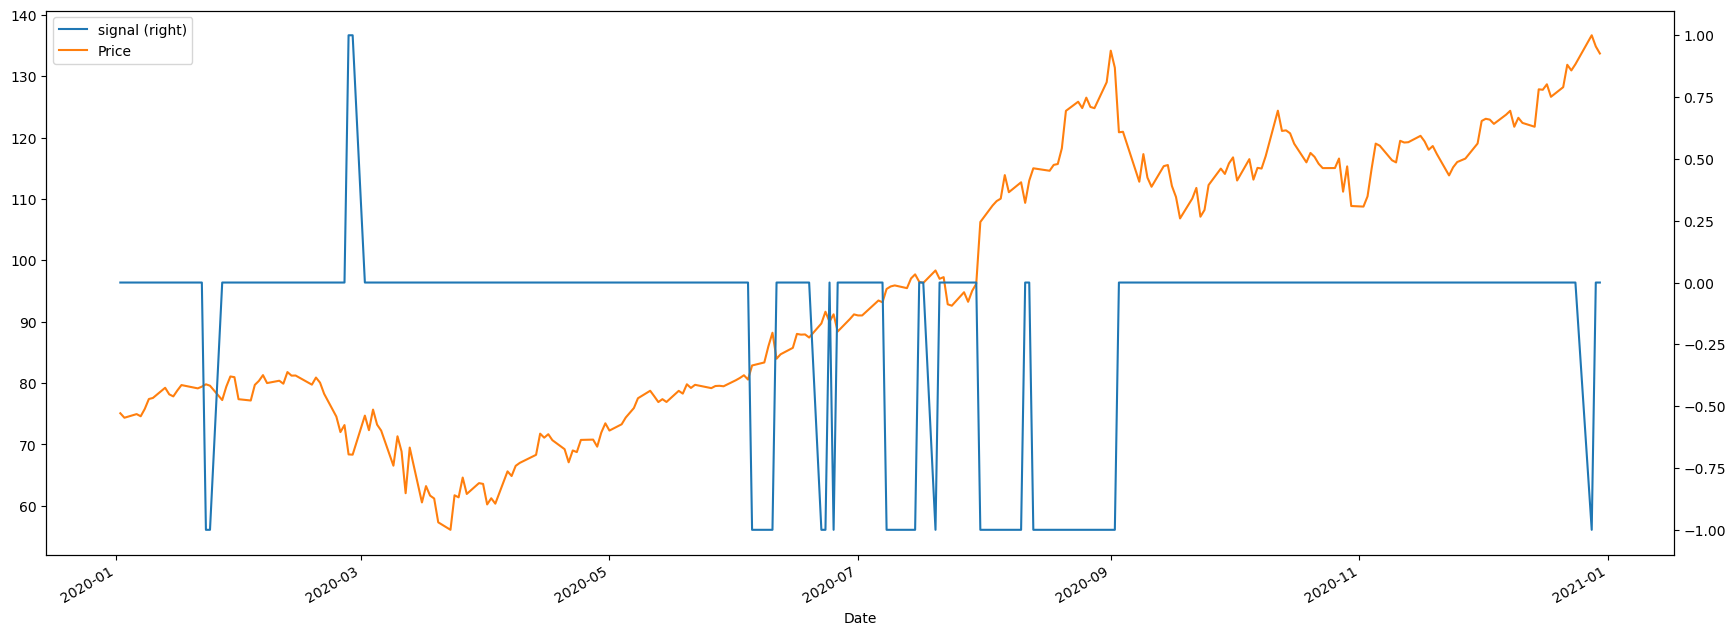

In [69]:
# Lets merge and plot
combined_data = bt.merge(signal, data.Close)
combined_data.columns = ['signal', 'Price']
combined_data.plot(secondary_y=['signal'], figsize=(21,8))

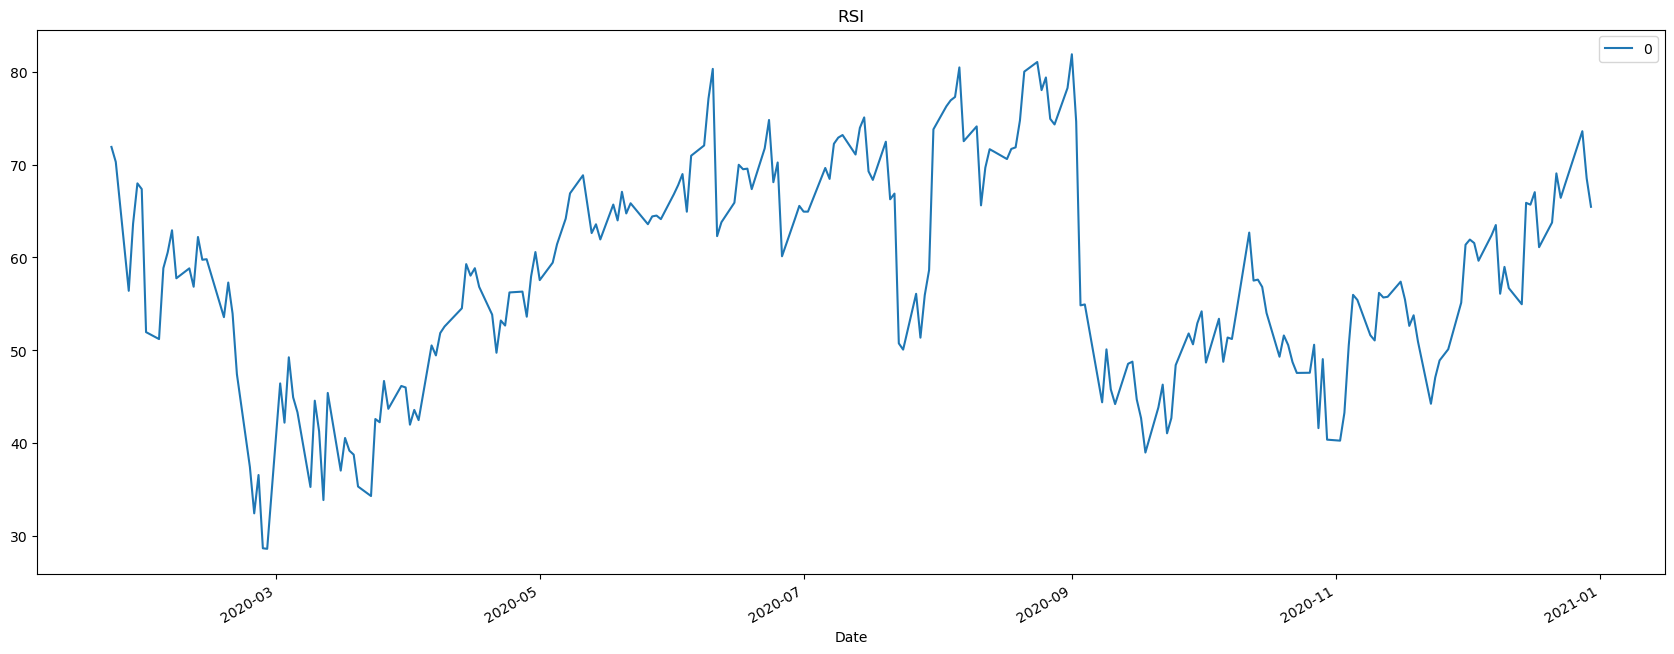

In [70]:
RSI.plot(figsize=(21,8))
plt.title('RSI')
plt.show()

In [71]:
bt_strategy = bt.Strategy(
    'RSI_divergence',
    [bt.algos.WeighTarget(signal),
     bt.algos.Rebalance()]
)

In [72]:
bt_backtest = bt.Backtest(bt_strategy, data)

In [74]:
result = bt.run(bt_backtest)

100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


<Axes: title={'center': 'Equity Progression'}>

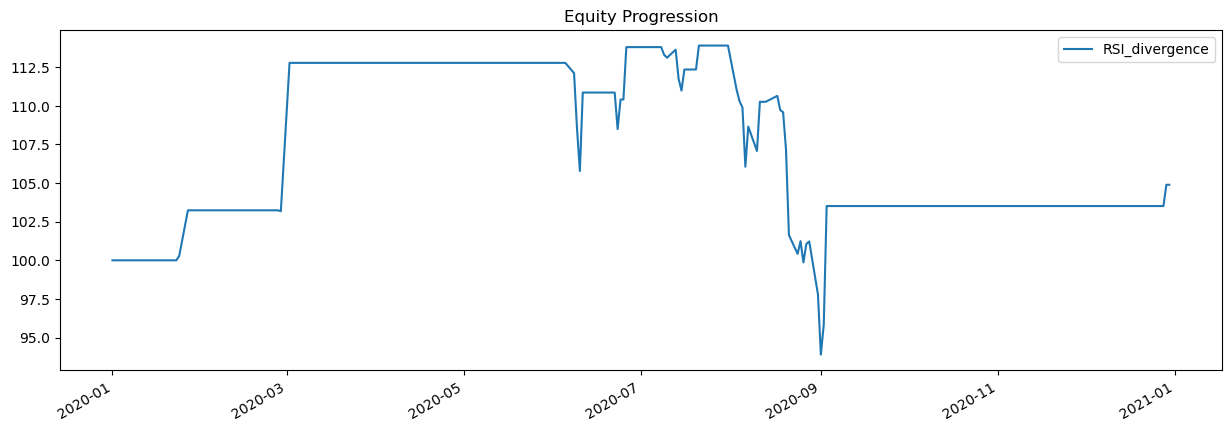

In [75]:
result.plot()

In [76]:
result.display()

Stat                 RSI_divergence
-------------------  ----------------
Start                2020-01-01
End                  2020-12-30
Risk-free rate       0.00%

Total Return         4.89%
Daily Sharpe         0.35
Daily Sortino        0.63
CAGR                 4.91%
Max Drawdown         -17.57%
Calmar Ratio         0.28

MTD                  1.33%
3m                   1.33%
6m                   -7.83%
YTD                  4.89%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  4.91%

Daily Sharpe         0.35
Daily Sortino        0.63
Daily Mean (ann.)    6.39%
Daily Vol (ann.)     18.22%
Daily Skew           3.04
Daily Kurt           29.49
Best Day             9.31%
Worst Day            -5.15%

Monthly Sharpe       0.18
Monthly Sortino      0.24
Monthly Mean (ann.)  3.58%
Monthly Vol (ann.)   19.68%
Monthly Skew         -1.41
Monthly Kurt         4.83
Best Month           9.31%
Worst Month          -14.15%

Yearly Sha

In [78]:
result.display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul     Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----  -----  -----
  2020   3.24  -0.06   9.31      0      0    0.9   0.09  -14.15   5.85      0      0   1.33   4.89
